# Project: Breast Cancer Incidence
***Group Members :***
    
    Kayleigh Habib - 200370580 - kayl26
    Myisha Chaudhry - 200591740 - myishac
    
***GitHub: https://github.com/wlu-labs/final-project-200370580-200591740***

# Introduction
The purpose of this analysis is to determine how effectively can supervised models be used to determine whether a mass indicated in a mammogram is benign or malignant.

In [36]:
# to catch any warnings
import warnings
warnings.filterwarnings("ignore")

# Load libraries
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import packages that will be used in PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Import packages that will be used in model building and evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

## Load and Describe Data

The data used was retrieved from the University of California, Irvine (UCI) Machine Learning repository (http://archive.ics.uci.edu/ml/datasets/mammographic+mass) and represents data that was collected by the Institute of Radiology of the University Erlangen-Nuremberg, Germany.


In [2]:
#Load Data
mammogramdata = pd.read_csv("mammographic_masses.data", names = ["BI-RADS assessment", "Age", "Shape", "Margin", "Density", "Severity"])
mammogramdata.replace("?", np.nan, inplace=True)
mammogramdata.head(5)


,BI-RADS assessment,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,NaN,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,NaN,1


In [3]:
# Look at the makeup of the data
mammogramdata.info()
#961 rows of 5 variables and 1 target (severity)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   BI-RADS assessment  959 non-null    object
 1   Age                 956 non-null    object
 2   Shape               930 non-null    object
 3   Margin              913 non-null    object
 4   Density             885 non-null    object
 5   Severity            961 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 45.2+ KB


# Current Methodology for Classifying Mammogram Masses

Under the current methodology, mammogram masses are examined by radiologists, and a BI-RADS assessment is assigned. According to https://radiopaedia.org/articles/breast-imaging-reporting-and-data-system-bi-rads the assessment is interpreted as follows:
0 - incomplete (repeat mammogram)
1 - negative
2 - benign 
3 - likely benign (<2% probability of malignancy). Follow up in shortened interval.
4 - suspected malignant (biopsy recommended)
5 - highly likely to be malignant
6 - malignant but only assigned after biopsy confirmation

For our analysis, we will remove any observations with 0 or 6, and will group 1-3 as negative, and 4-5 as positive.

In [4]:
# create a dataframe with only the BI-RADS assessment and Severity columns
# Remove any rows with missing bi-rads values
birads = mammogramdata.loc[:, ['BI-RADS assessment', 'Severity']]


birads['BI-RADS assessment'] = birads['BI-RADS assessment'].replace({'0':np.nan,'6':np.nan, '55':'5'}).dropna()
birads.value_counts()

# replace BI-RADS assessment with a 0 or 1, based on information from *****
birads['BI-RADS assessment'] = birads['BI-RADS assessment'].replace({'1':0, '2':0, '3':0, '4':1, '5':1})
birads['BI-RADS assessment'].value_counts()


#calculate values for confusion matrix
truepositive = sum((birads['BI-RADS assessment'] == 1) & (birads['Severity'] == 1))
falsepositive = sum((birads['BI-RADS assessment'] == 1) & (birads['Severity'] == 0))
falsenegative = sum((birads['BI-RADS assessment'] == 0) & (birads['Severity'] == 1))
truenegative = sum((birads['BI-RADS assessment']  == 0) & (birads['Severity'] == 0))
print(truepositive, falsepositive, falsenegative, truenegative)

# Create and display confusion matrix
birad_cm = np.array([[truenegative, falsepositive],[falsenegative, truepositive]])
birad_cm

# From this summary it appears that the majority of mammogram masses (over 90%) are classified as malignant under
# the BI-RADS assessment. 

426 467 7 43


array([[ 43, 467],
       [  7, 426]])

### Attribute Information

The data contains 961 records of mammogram masses in 6 columns. These columns contain the following information:

BI-RADS assessment: 1 to 5 (ordinal, non-predictive!)

Age: patient's age in years (integer)

Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)

Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)

Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

Severity: benign=0 or malignant=1 (binominal, target)


The Breast Imaging Reporting and Data System (BI-RADS) assessment is assigned by a doctor after examination of the mammogram results. As this is based primarily of the shape, margin, and density attributes, it is considered non-predictive so it will not be used in the model. Instead, this can be used to compare against the model predictions to determine whether any of the models out-perform these assessments.

Severity is the target variable and denotes whether a mass is assessed to be benign (non-cancerous) or malignant.

# Review and Clean Data

In [5]:
#The BI-RADS variable is not-predictive so it is removed from the data
mammoData = mammogramdata.drop(['BI-RADS assessment'], axis=1)
mammoData.head()

,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,43,1,1,NaN,1
2,58,4,5,3,1
3,28,1,1,3,0
4,74,1,5,NaN,1


In [6]:
#Check for missing values
missing_mammvalues = mammoData.isnull().sum().sort_values(ascending = False)
missing_mammvalues 
# missing values exist for each one of the predictors. No missing values in target.

Density     76
Margin      48
Shape       31
Age          5
Severity     0
dtype: int64

In [7]:
#Most of the records with missing values may have to be dropped
#Can examine missing Age which occurs in only 5 cases

#change Age to integer
# substitute median for the missing Age values
mammoData['Age'] = mammoData['Age'].fillna(mammoData['Age'].median()).astype('int')

mammoData['Age'].describe()

count    961.000000
mean      55.495317
std       14.442783
min       18.000000
25%       45.000000
50%       57.000000
75%       66.000000
max       96.000000
Name: Age, dtype: float64

In [8]:
#Drop the records that still contain missing values
mammoData = mammoData.dropna()
mammoData.info()
#there are 836 records remaining

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836 entries, 0 to 960
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Age       836 non-null    int64 
 1   Shape     836 non-null    object
 2   Margin    836 non-null    object
 3   Density   836 non-null    object
 4   Severity  836 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [9]:
# Change Density variable to integer as it is an ordinal value
mammoData['Density'].astype('int')
mammogramdata['Density'].value_counts(ascending=False)

3    798
2     59
1     16
4     12
Name: Density, dtype: int64

# Model Planning

## Exploratory Data Analysis
We now look at the variables in the data to determine how their values are distributed, and how the attributes are related to the target. Based on the following charts, the dataset seems well-balanced with respect to the target (51% benign and 49% malignant). There does not appear to be any outliers in the values of predictors.

In [10]:
#Look at distribution of target variable in the data

mammoData['Severity'].value_counts(normalize = True)

# Data is balanced with about 51% benign cases and 49% malignant cases

0    0.511962
1    0.488038
Name: Severity, dtype: float64

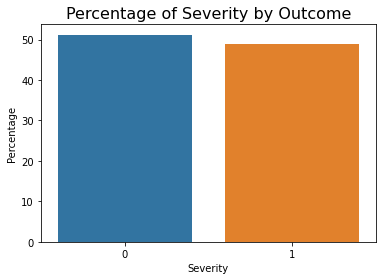

In [11]:
#Look at distribution of target variable in the data

plotData =mammoData['Severity'].value_counts(normalize=True)*100
newData = plotData.to_frame().reset_index()
newData.columns = ['Severity', 'Percentage']
#ewData.head()

sns.barplot(data=newData, x='Severity', y ='Percentage');
plt.title('Percentage of Severity by Outcome', fontsize = 16);


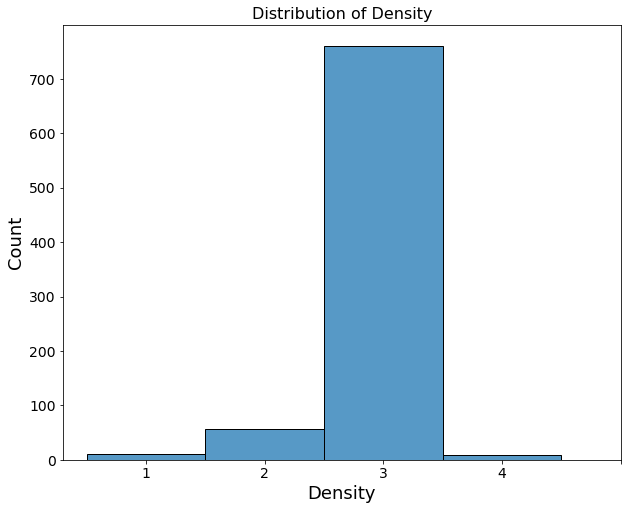

In [12]:
# Look at Distribution of Density variable
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
# Plot frequency plot/ histogram to look for distribution as well as outliers
sns.histplot(x="Density", kde=False, data=mammoData.sort_values('Density'), ax=axes, bins=4);
axes.set(xlabel="Density");
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
axes.tick_params('y', labelsize = 14);
axes.tick_params('x', labelsize = 14);
plt.xticks([0,1,2,3,4]);
plt.title('Distribution of Density', fontsize=16);

#The majority of masses are classified as Density 3 (low)


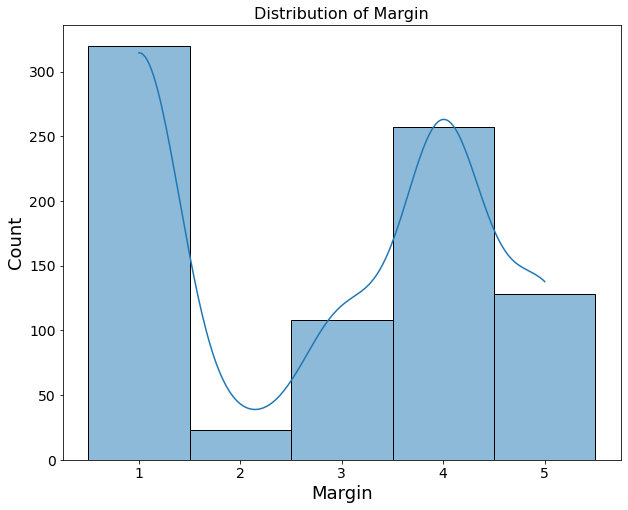

In [13]:
mammoData['Margin'].value_counts(ascending =False)

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot frequency plot/ histogram to look for distribution as well as outliers
sns.histplot(x="Margin", kde=True, data=mammoData.sort_values('Margin'), ax=axes, bins=5);
axes.set(xlabel="Margin");
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
axes.tick_params('y', labelsize = 14);
axes.tick_params('x', labelsize = 14);
plt.title('Distribution of Margin', fontsize=16);

# Most of the mammogram masses are in either the 1 or 4 category i.e. circumscribed or ill-defined

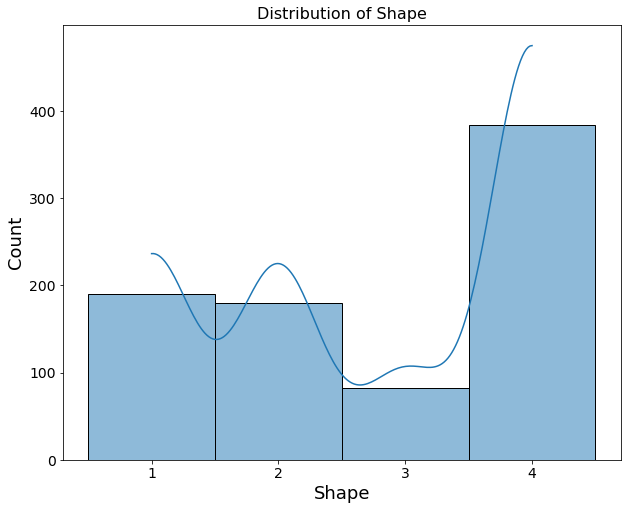

In [14]:
mammoData['Shape'].value_counts(ascending =False)

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot frequency plot/ histogram to look for distribution as well as outliers
sns.histplot(x="Shape", kde=True, data=mammoData.sort_values('Shape'),ax=axes, bins=4);
axes.set(xlabel="Shape");
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
axes.tick_params('y', labelsize = 14);
axes.tick_params('x', labelsize = 14);
plt.title('Distribution of Shape', fontsize=16);

# Category 3 (lobular) contains the least number of records

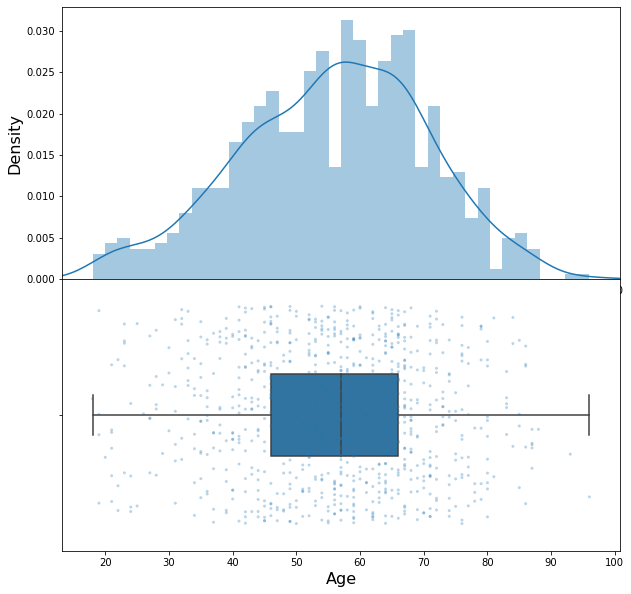

In [15]:
# Look at distribution of Age

fig, axs = plt.subplots(nrows=2, figsize=(10, 10))

sns.distplot(
   mammoData['Age'].values, 
    kde=True,
    bins = 40,
    ax=axs[0]
)

sns.stripplot(
    mammoData['Age'].values, 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)

sns.boxplot(
    mammoData['Age'].values,
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(mammoData['Age']) * 0.05
xmin = np.min(mammoData['Age']) - spacer
xmax = np.max(mammoData['Age']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

axs[1].set(xlabel='Age');
axs[1].xaxis.label.set_size(16)
axs[0].yaxis.label.set_size(16)


# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
#axs[1].artists[0].set_facecolor('white')

## Relationships between Predictors and Response

We now examine how each of the predictors is related to the target, as well as whether there are any collinearities among the predictors.

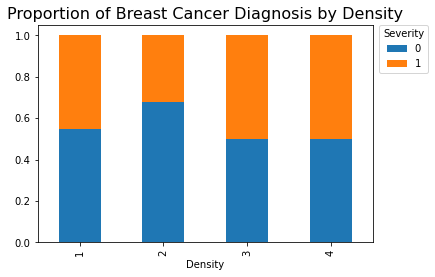

In [16]:
#create a stacked bar chart to show incidence of breast cancer by each Density class
pd.crosstab(mammoData['Density'],mammoData['Severity'],normalize='index').plot.bar(stacked=True)
plt.title("Proportion of Breast Cancer Diagnosis by Density", fontsize=16);
#plt.legend(loc='center right', title='Severity')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Severity');

#Desnity category 2 (iso) has a lower incidence of breast cancer than the other categories.

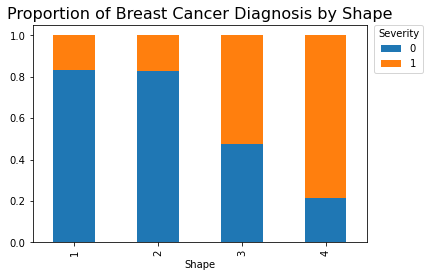

In [17]:
#create a stacked bar chart to show incidence of breast cancer by each shape class
pd.crosstab(mammoData['Shape'],mammoData['Severity'],normalize='index').plot.bar(stacked=True)
plt.title("Proportion of Breast Cancer Diagnosis by Shape", fontsize=16);
#plt.legend(loc='center right', title='Severity')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Severity');

#Shape categories 1 and 2 have lowest incidence of breast cancer. The incidence rate is about 50% for shape category 3,
#and increases to almoat 80% for Shape category 4.

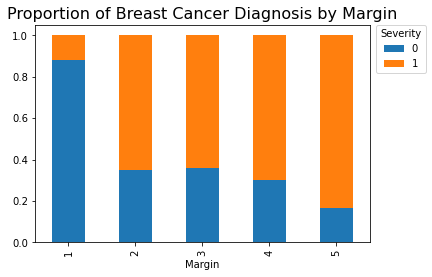

In [18]:
#create a stacked bar chart to show incidence of breast cancer by each margin class
pd.crosstab(mammoData['Margin'],mammoData['Severity'],normalize='index').plot.bar(stacked=True)
plt.title("Proportion of Breast Cancer Diagnosis by Margin", fontsize=16);
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Severity');
#Margin category 1 has low incidence of breast cancer. The incidence rate increases with each subsequent category,
#and is highest for Margin category 5.

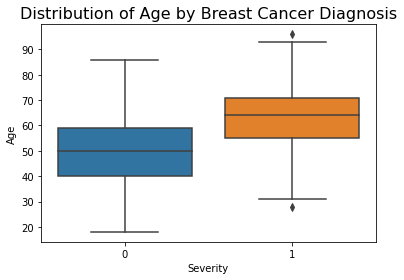

In [19]:
sns.boxplot(data=mammoData, x="Severity", y="Age")
plt.title('Distribution of Age by Breast Cancer Diagnosis', fontsize=16)
sns.set(rc = {'figure.figsize':(8,6)});
#Incidence of breast cancer appears to be more likely at higher ages

## Feature Engineering

## Correlation matrix

***Talk about pairplots***

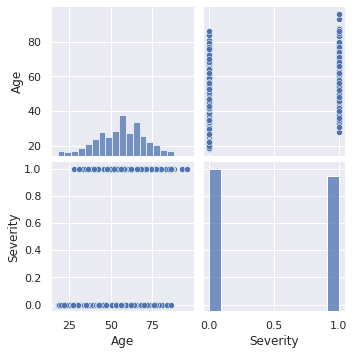

In [20]:
sns.pairplot(mammoData);

## Principal Component Analysis
Principal components analysis (PCA) is an unsupervised learning method that can be used for dimenionality reduction. In the mammographic mass data, there are only 4 features, so it is not considered high-dimensional. However, we will explore the application of PCA to better understand the relationships between the features as well as to the target.

In [21]:
#Explore Principle Components Analysis 

#Create data without target variable
mammo_features = mammoData.drop(['Severity'], axis=1)
mammo_target = mammoData['Severity']

#Scale the feature columns
scaler = StandardScaler()
scaler.fit(mammo_features)
mammoFeatures_s = scaler.transform(mammo_features)

col_names = list(mammo_features.columns.values)
mammoFeatures_s = pd.DataFrame(mammoFeatures_s, columns=col_names)
mammoFeatures_s.head()

,Age,Shape,Margin,Density
0,0.767588,0.169679,1.393444,0.239552
1,0.151618,0.975657,1.393444,0.239552
2,-1.901613,-1.442275,-1.164007,0.239552
3,0.083177,-1.442275,1.393444,0.239552
4,1.383557,-1.442275,0.754081,0.239552


In [22]:
#Apply pca analysis
pca = PCA()
pca_mammo = pca.fit_transform(mammoFeatures_s)


# Reformat and view results
loadings = (pd.DataFrame(pca.components_, columns=['pc1', 'pc2', 'pc3','pc4'],
                            index=mammo_features.columns))
print(loadings)

mammoData_pca = pd.DataFrame(pca_mammo, columns = ['pc1', 'pc2', 'pc3','pc4'])
mammoData_pca.head()

# Talk about PCA and what it means (put more info into - K)
# first component age and margin are most important
# second component age and density
# third component age and density
# fourth component shape (not important overall)

              pc1       pc2       pc3       pc4
Age     -0.469405 -0.609182 -0.623743 -0.139644
Shape    0.127863  0.094379  0.032516 -0.986756
Margin   0.871943 -0.385116 -0.294938  0.066432
Density -0.055008 -0.686786  0.723117 -0.048988


,pc1,pc2,pc3,pc4
0,-1.366278,-0.076910,0.208880,0.837132
1,-1.568126,-0.079602,-0.638605,0.317481
2,2.463825,-0.653494,-0.743430,0.241689
3,-0.063039,-0.316555,0.232904,1.981848
4,-0.274646,-0.171074,1.555333,1.447982


,pc1,pc2,pc3,pc4,Severity
0,-1.366278,-0.076910,0.208880,0.837132,1
1,-1.568126,-0.079602,-0.638605,0.317481,1
2,2.463825,-0.653494,-0.743430,0.241689,0
3,-0.063039,-0.316555,0.232904,1.981848,1
4,-0.274646,-0.171074,1.555333,1.447982,1


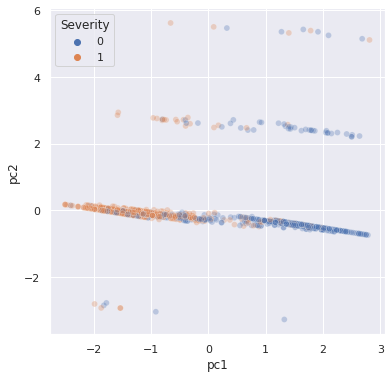

In [23]:
mammo_target = mammo_target.reset_index(drop=True)
concatenated = pd.concat([mammoData_pca, mammo_target], axis=1)
#concatenated
plt.figure(figsize=(6,6))
sns.scatterplot(
    x="pc1", y="pc2",
    hue= "Severity",
    #palette=sns.color_palette("hls", 10),
    data=concatenated,
    legend="full",
    alpha=0.3
)
concatenated.head()

#From the graph, it appears that the two classes (benign and malignant), when projected to a two-dimensional space,
#can be somewhat linearly separable.

In [24]:
df = pd.DataFrame({'Variance Explained %':pca.explained_variance_ratio_*100,
             'Principal Components':['PC1','PC2', 'PC3', 'PC4']})
#sns.barplot(x='Principal Components',y="Variance Explained %", data=df, color="b")
#plt.title("Variance Explained by Each PC\n", fontsize=20, color="b")
#plt.show()
print('Explained variation per principal component: {}'.format((pca.explained_variance_ratio_)*100))

Explained variation per principal component: [51.64260507 24.54675435 17.36215765  6.44848294]


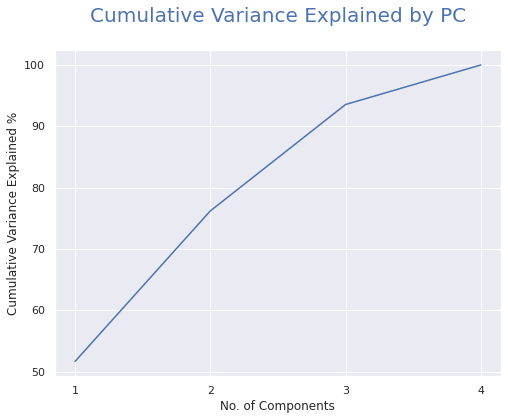

In [25]:
df = pd.DataFrame({'Cumulative Variance Explained %':np.cumsum(pca.explained_variance_ratio_)*100,
             'No. of Components':['1','2', '3', '4']})
sns.lineplot(x='No. of Components',y="Cumulative Variance Explained %", data=df, color="b")
plt.title("Cumulative Variance Explained by PC\n", fontsize=20, color="b")
plt.show()

#The graph shows that over 90% of the variance is explained by the first 3 principal components. 
#While not a material decrease from all 4 features available in the data, it is possible to use
#principal component analysis to decrease model run time without material decrease in performance.

# Model Building

## Split Data into Train and Test

We start by splitting the data into a training set and a test set. The test set will be set aside to be used for comparing the performance of models only after all the models have been fitted.
When building models, it is possible that the model is over-fitted to data used for training and will thus perform poorly on unseen data. This is usually indicated by high training data accuracy, but low validation data accuracy. To avoid overfitting, we can 

a. further split the training data into separate train and validation datasets. The train dataset can be used for training the model, while the validation dataset is used to determine how well the model predicts on a new set of data 

OR 

b. use k-fold cross-validation to repeatedly split the training data into separate folds where each fold contains a set of train data as well as validation data. This is set up such that each record is in the validation set for at least one-fold.


In [26]:
# Using first 3 Principal Components

#Cross validation will be used to fit the models
#the test set will be used to compare the performance of each of the model types
pca_mammoData = concatenated.drop(['pc4'], axis=1)
trainPC, valPC = train_test_split(pca_mammoData, test_size=0.2, random_state=2002)
XPC_train = trainPC.drop(['Severity'], axis=1)
yPC_train = trainPC.loc[:,'Severity']

XPC_test = valPC.drop(['Severity'], axis=1)
yPC_test = valPC.loc[:,'Severity']

In [27]:
XPC_train.head()

,pc1,pc2,pc3
718,1.794073,2.403135,-0.169702
106,2.197724,-0.638684,-1.471561
166,2.500858,2.210612,-1.482588
445,2.004965,-0.586178,-1.113501
72,-0.366163,-0.319168,-1.941949


## Cross Validation to determine best parameters

In [28]:
#tune parameters using PCA data
def tuneParams(model, params, cv):
    model_cv = GridSearchCV(model, params, cv=10)
    model_cv.fit(XPC_train,yPC_train)
    print('tuned hyperparameters :(best parameters) ', model_cv.best_params_)
    print('accuracy :', model_cv.best_score_)
    return


#Calculate accuracy
def calcAcc(model, modelName):
    final_model = model.fit(XPC_train, yPC_train)
    training_accuracy = final_model.score(XPC_train, yPC_train)
    print("Training Accuracy for",str(modelName),"is: ", training_accuracy)
    return final_model

## Model 1 - Logistic Regression

The first model will be a logistic regression, which will be used to classify the results as either benign (0) or malignant (1). The logistic regression model will determine the probability that a record belongs to one of these classes. In order to assign the record to a specific class, we then set a cut-off or threshold, so that if the probability exceed this amount, the record will be labelled as "1" i.e. malignant. The threshold can be set to reduce the occurrence of false positives and false negatives.

In [29]:
# Try a logistic Regression model
lr_model_1 = LogisticRegression(fit_intercept=True)
all_accuracies_lr = cross_val_score(estimator=lr_model_1, X=XPC_train, y=yPC_train, scoring='accuracy', cv=10)
print(all_accuracies_lr)
print(all_accuracies_lr.mean())
print(all_accuracies_lr.std())

[0.7761194  0.71641791 0.91044776 0.85074627 0.89552239 0.79104478
 0.79104478 0.73134328 0.75757576 0.78787879]
0.8008141112618725
0.06186187525412794


In [30]:
#Use grid search and cross validation to tune parameters for logistic regression model

lrparams={'C':np.logspace(-2,4,20), 'solver' :['newton-cg','lbfgs', 'liblinear'], 'penalty':['l1','l2']}# l1 lasso l2 ridge
lr_model_2=LogisticRegression()

tuneParams(lr_model_2, lrparams, 10)

tuned hyperparameters :(best parameters)  {'C': 0.08858667904100823, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.8083220262324741


In [31]:
#Print accuracy for final model
lr_model = LogisticRegression(solver='liblinear', C = 0.0885866792, penalty = 'l2')
final_lr = calcAcc(lr_model, 'Logistic Regression')

Training Accuracy for Logistic Regression is:  0.8083832335329342


## Model 2 - Decision Tree Model

A decision tree works by recursively dividing the inputs into decisions, where nodes represent features, and branches are the decisions made to divide the data. The leaves of the tree represent the outcome for each record. Decision tree models are very interpretable, but often suffers from over-fitting. This can be overcome by pruning the tree, or by setting limits on the number of leaf nodes.

In [32]:
# Try a decision tree model
dt_model_1 = tree.DecisionTreeClassifier()
all_accuracies_dt = cross_val_score(estimator=dt_model_1, X=XPC_train, y=yPC_train, scoring='accuracy', cv=10)
print(all_accuracies_dt)
print(all_accuracies_dt.mean())
print(all_accuracies_dt.std())

[0.73134328 0.68656716 0.82089552 0.71641791 0.7761194  0.67164179
 0.74626866 0.74626866 0.66666667 0.77272727]
0.7334916327453641
0.04702288698648939


In [33]:
#Use grid search and cross validation to tune parameters for tree model

treeparams = {'max_leaf_nodes': list(range(2, 12)), 'min_samples_split': [2, 3, 4], 'max_depth': [5,7,9], 'criterion': ['gini', 'entropy']}
dt_model_2 = tree.DecisionTreeClassifier(random_state=0)

tuneParams(dt_model_2, treeparams, 10)

tuned hyperparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 2, 'min_samples_split': 2}
accuracy : 0.8068068747173225


In [34]:
#Print accuracy for final model
tree_model = tree.DecisionTreeClassifier(criterion = 'gini',max_leaf_nodes = 2, min_samples_split =2 ,  max_depth = 5)
final_tree = calcAcc(tree_model, 'Decision Tree')

Training Accuracy for Decision Tree is:  0.812874251497006


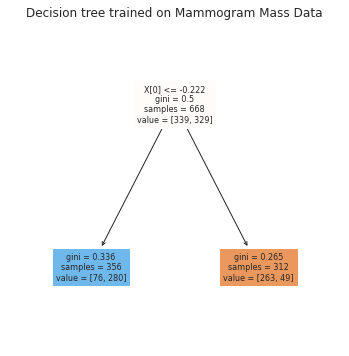

In [37]:
#Plot the tree
plt.figure(figsize=(6,6))
plot_tree(final_tree,  fontsize=8, filled=True)
plt.title("Decision tree trained on Mammogram Mass Data")
plt.show()

## Model 3 : K-nearest Neighbours Model
The K-nearest neighbours approach groups individual observations into categories based on its proximity to other similar data records. The k-nearest neighbours approach is relatively simple to implement due to the small number of parameters but does not perform well when data is high-dimensional as it tends to overfit.


In [38]:
# Build a K-Nearest Neighbours Model
k_model_1 = KNeighborsClassifier()
all_accuracies_km = cross_val_score(estimator= k_model_1, X=XPC_train, y=yPC_train, scoring='accuracy', cv=10)
print(all_accuracies_km)
print(all_accuracies_km.mean())
print(all_accuracies_km.std())

[0.79104478 0.73134328 0.85074627 0.82089552 0.80597015 0.73134328
 0.7761194  0.74626866 0.72727273 0.86363636]
0.7844640434192673
0.04789327556678665


In [39]:
#Use grid search and cross validation to tune parameters for knn model
knnparams = {'n_neighbors' :list(range(1, 20)), 'weights': ['uniform', 'distance']}
k_model_2 = KNeighborsClassifier()

tuneParams(k_model_2, knnparams, 10)

tuned hyperparameters :(best parameters)  {'n_neighbors': 19, 'weights': 'uniform'}
accuracy : 0.8053821800090457


In [40]:
knn_model =  KNeighborsClassifier(n_neighbors=19, weights='uniform')
final_knn = calcAcc(knn_model, 'K-Nearest Neighbours')

Training Accuracy for K-Nearest Neighbours is:  0.8098802395209581


## Model 4: Random Forest
* write a description of what it is

In [41]:
# define final model as final_rf
rf_model_1 = RandomForestClassifier(random_state = 1)
all_accuracies_rf = cross_val_score(estimator= rf_model_1, X=XPC_train, y=yPC_train, scoring='accuracy', cv=10)
print(all_accuracies_rf)
print(all_accuracies_rf.mean())
print(all_accuracies_rf.std())

[0.74626866 0.74626866 0.86567164 0.79104478 0.80597015 0.73134328
 0.74626866 0.79104478 0.71212121 0.78787879]
0.7723880597014926
0.042578314223861824


In [42]:
#Use grid search and cross validation to tune parameters for Random Forests model
rfparams = {'max_depth' : range(1,10),'criterion' :['gini', 'entropy']}
rf_model_2 = RandomForestClassifier()

tuneParams(rf_model_2, rfparams, 10)

tuned hyperparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4}
accuracy : 0.8098145635459069


In [43]:
rf_model = RandomForestClassifier(criterion = 'gini',max_depth = 6)
final_rf = calcAcc(rf_model, 'Random Forests')

Training Accuracy for Random Forests is:  0.8532934131736527


## Model 5: SVM 
* write a description of what it is

In [44]:
# define final model as final_svm
svm_model_1 = svm.SVC(kernel='rbf', random_state = 1)
all_accuracies_svm = cross_val_score(estimator= svm_model_1, X=XPC_train, y=yPC_train, scoring='accuracy', cv=10)
print(all_accuracies_svm)
print(all_accuracies_svm.mean())
print(all_accuracies_svm.std())

[0.7761194  0.70149254 0.88059701 0.80597015 0.92537313 0.76119403
 0.79104478 0.7761194  0.74242424 0.8030303 ]
0.7963364993215739
0.06153882345274332


In [45]:
svmparams = {'gamma' : ['scale', 'auto'], 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}
svm_model_2 = svm.SVC()

tuneParams(svm_model_2, svmparams, 10)

tuned hyperparameters :(best parameters)  {'gamma': 'scale', 'kernel': 'linear'}
accuracy : 0.7978290366350067


In [46]:
svm_model = svm.SVC(kernel = "linear", gamma = "scale", probability = True)
final_svm = calcAcc(svm_model, 'SVM')

Training Accuracy for SVM is:  0.7994011976047904


## Model 6: ANN (Artificial Neural Network)
* write a description of what it is

In [47]:
# build an untuned ann model
# NEED RANDOM_STATE
ann_model_1 = MLPClassifier(hidden_layer_sizes=(8), activation='relu', solver='adam', max_iter=500)
ann_model_1.fit(XPC_train,yPC_train)

predict_train = ann_model_1.predict(XPC_train)
predict_test = ann_model_1.predict(XPC_test)


all_accuracies_ann = cross_val_score(estimator= ann_model_1, X=XPC_train, y=yPC_train, scoring='accuracy', cv=10)
print(all_accuracies_ann)
print(all_accuracies_ann.mean())
print(all_accuracies_ann.std())

[0.79104478 0.71641791 0.91044776 0.82089552 0.88059701 0.74626866
 0.7761194  0.7761194  0.77272727 0.77272727]
0.7963364993215739
0.05619464864594115


In [48]:
#Use grid search and cross validation to tune parameters for ann model
annparams = {'hidden_layer_sizes' :[ (3), (5), (3,5)],
             'activation':['identity', 'logistic', 'relu'],
             'solver': ['lbfgs', 'sgd', 'adam'], 
             'max_iter':[1000, 1200]}
a_model_2 = MLPClassifier()

tuneParams(a_model_2, annparams, 10)

tuned hyperparameters :(best parameters)  {'activation': 'relu', 'hidden_layer_sizes': 5, 'max_iter': 1200, 'solver': 'lbfgs'}
accuracy : 0.8083672546359114


In [49]:
#build tuned ann model

ann_model =  MLPClassifier(hidden_layer_sizes=(3), activation='identity', solver='adam', max_iter=1000)
final_ann = calcAcc(ann_model, 'Artificial Neural Network')

Training Accuracy for Artificial Neural Network is:  0.8083832335329342


# Compare Models

We will use the test data that was set aside prior to doing any model-building to compare the performance of the 3 classification model approaches used above.

One of the most commonly used methods to assess results of a classification model is the confusion matrix. The classification models above are all used for assigning each record to one of two classes i.e. benign (0) or malignant (1). 

A confusion matrix is used to categorize counts that line up predicted classes versus actual classes

There are two types of errors that could occur: 

- False positive (FP): a benign mass is mis-classified as malignant 

- False negative (FN): a malignant mass is mis-classified as benign

Using these values, the following can be calculated: Precision = TP/(TP+FP) i.e. proportion of masses classified as malignant that are actually malignant.

- Recall = TP/(TP+FN) i.e. proportion of malignant masses correctly classified as malignant.

- False-alarm rate = FP/(FP+TN) i.e. proportion of benign masses incorrectly classified as malignant.

- False negative rate = FN/(FN+TP) i.e. proportion of malignant masses incorrectly classified as benign.

In the case of a breast-cancer classification, presumably a false negative would be harmful, as someone with breast cancer can be falsely given a clean bill of health. Without early detection, this patient will not be able to receive early intervention, which can lead to a poor future prognosis. However, a low FNR can be achieved by bypassing screening and sending every patient for an invasive biopsy, which is not desirable either. Thus, models will be assessed by several metrics in order to determine the most appropriate approach.

In order to compare the predictive performance of each model, we will plot ROC curves which are a measure of sensitivity of the model and calculate the Area Under the Curve (AUC). A higher AUC indicates a model with more predictive power.




In [50]:
def predictions(model):
    y_predict_class = model.predict(XPC_test)
    return y_predict_class

def confMatrix(y_predict, modelName):
    print(confusion_matrix(yPC_test, y_predict))
    print('Classification Report for',str(modelName),'\n',classification_report(yPC_test, y_predict))
    return

In [51]:
# predict and confusion matrix for Logistic Regression
y_predict_class_lr = predictions(final_lr)
confMatrix(y_predict_class_lr, 'Logistic Regression')

[[65 24]
 [12 67]]
Classification Report for Logistic Regression 
               precision    recall  f1-score   support

           0       0.84      0.73      0.78        89
           1       0.74      0.85      0.79        79

    accuracy                           0.79       168
   macro avg       0.79      0.79      0.79       168
weighted avg       0.79      0.79      0.79       168



In [52]:
# predict and confusion matrix for Decision Tree
y_predict_class_tree = predictions(final_tree)
confMatrix(y_predict_class_tree, 'Decision Tree')

[[67 22]
 [13 66]]
Classification Report for Decision Tree 
               precision    recall  f1-score   support

           0       0.84      0.75      0.79        89
           1       0.75      0.84      0.79        79

    accuracy                           0.79       168
   macro avg       0.79      0.79      0.79       168
weighted avg       0.80      0.79      0.79       168



In [53]:
# predict and confusion matrix for K-Nearest Neighbours
y_predict_class_knn = predictions(final_knn)
confMatrix(y_predict_class_knn, 'K-Nearest Neighbours')

[[65 24]
 [14 65]]
Classification Report for K-Nearest Neighbours 
               precision    recall  f1-score   support

           0       0.82      0.73      0.77        89
           1       0.73      0.82      0.77        79

    accuracy                           0.77       168
   macro avg       0.78      0.78      0.77       168
weighted avg       0.78      0.77      0.77       168



In [54]:
# predict and confusion matrix for Random Forest
y_predict_class_rf = predictions(final_rf)
confMatrix(y_predict_class_rf, 'Random Forest')

[[64 25]
 [11 68]]
Classification Report for Random Forest 
               precision    recall  f1-score   support

           0       0.85      0.72      0.78        89
           1       0.73      0.86      0.79        79

    accuracy                           0.79       168
   macro avg       0.79      0.79      0.79       168
weighted avg       0.80      0.79      0.79       168



In [55]:
# predict and confusion matrix for SVM
y_predict_class_svm = predictions(final_svm)
confMatrix(y_predict_class_svm, 'Support Vector Machine')

[[65 24]
 [ 7 72]]
Classification Report for Support Vector Machine 
               precision    recall  f1-score   support

           0       0.90      0.73      0.81        89
           1       0.75      0.91      0.82        79

    accuracy                           0.82       168
   macro avg       0.83      0.82      0.82       168
weighted avg       0.83      0.82      0.81       168



In [56]:
# predict and confusion matrix for ANN
y_predict_class_ann = predictions(final_ann)
confMatrix(y_predict_class_ann, 'Artificial Neural Networks')

[[65 24]
 [12 67]]
Classification Report for Artificial Neural Networks 
               precision    recall  f1-score   support

           0       0.84      0.73      0.78        89
           1       0.74      0.85      0.79        79

    accuracy                           0.79       168
   macro avg       0.79      0.79      0.79       168
weighted avg       0.79      0.79      0.79       168



In [57]:
#Calculate metrics for each model using test data:
def calcMetrics(y_act, y_pred, model):
    tn, fp, fn, tp = confusion_matrix(list(y_act), list(y_pred), labels=[0, 1]).ravel()
    acc = round((tp+tn)/(tp+tn+fp+fn) *100,2)
    prec = round((tp)/(tp+fp) *100,2)
    far = round((fp)/(fp+tn) *100,2)
    fnr = round(fn/(fn+tp) *100,2)
    print("The accuracy for",str(model), 'is:',acc,'%')
    print("The precision for",str(model), 'is:',prec,'%')
    print("The false alarm rate for",str(model), 'is:',far,'%')
    print("The false negative Rate for",str(model), 'is:',fnr,'%\n')
    return 


def calc_auc(y_preds, model):
    auc = metrics.roc_auc_score(yPC_test, y_preds)
    print("The AUC for", str(model),"is:",auc)
    return

In [58]:
# prints out all the metrics for each model
calcMetrics(yPC_test, y_predict_class_lr, 'Logistic Regression')
calcMetrics(yPC_test, y_predict_class_tree, "Decision Tree")
calcMetrics(yPC_test, y_predict_class_knn, "K-Nearest Neighbours")

calcMetrics(yPC_test, y_predict_class_rf, "Random Forest")
calcMetrics(yPC_test, y_predict_class_svm, "SVM")
calcMetrics(yPC_test, y_predict_class_ann, "ANN")

The accuracy for Logistic Regression is: 78.57 %
The precision for Logistic Regression is: 73.63 %
The false alarm rate for Logistic Regression is: 26.97 %
The false negative Rate for Logistic Regression is: 15.19 %

The accuracy for Decision Tree is: 79.17 %
The precision for Decision Tree is: 75.0 %
The false alarm rate for Decision Tree is: 24.72 %
The false negative Rate for Decision Tree is: 16.46 %

The accuracy for K-Nearest Neighbours is: 77.38 %
The precision for K-Nearest Neighbours is: 73.03 %
The false alarm rate for K-Nearest Neighbours is: 26.97 %
The false negative Rate for K-Nearest Neighbours is: 17.72 %

The accuracy for Random Forest is: 78.57 %
The precision for Random Forest is: 73.12 %
The false alarm rate for Random Forest is: 28.09 %
The false negative Rate for Random Forest is: 13.92 %

The accuracy for SVM is: 81.55 %
The precision for SVM is: 75.0 %
The false alarm rate for SVM is: 26.97 %
The false negative Rate for SVM is: 8.86 %

The accuracy for ANN is: 7

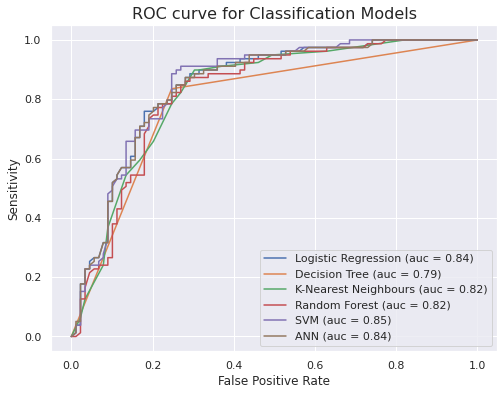

In [59]:
#Get predictions on val and plot roc_curve

# Using .predict_proba(...) method to get probabilities, not classes
#get predictions 
y_predict_lr = final_lr.predict_proba(XPC_test)[:,1]
y_predict_tree = final_tree.predict_proba(XPC_test)[:,1]
y_predict_knn = final_knn.predict_proba(XPC_test)[:,1]

y_predict_rf = final_rf.predict_proba(XPC_test)[:,1]
y_predict_svm = final_svm.predict_proba(XPC_test)[:,1]
y_predict_ann = final_ann.predict_proba(XPC_test)[:,1]

# plot roc
false_pos_lr, sens_lr, thresh_lr = roc_curve(yPC_test, y_predict_lr)
false_pos_tree, sens_tree, thresh_tree = roc_curve(yPC_test, y_predict_tree)
false_pos_knn, sens_knn, thresh_knn = roc_curve(yPC_test, y_predict_knn)

false_pos_rf, sens_rf, thresh_rf = roc_curve(yPC_test, y_predict_rf)
false_pos_svm, sens_svm, thresh_svm = roc_curve(yPC_test, y_predict_svm)
false_pos_ann, sens_ann, thresh_ann = roc_curve(yPC_test, y_predict_ann)

# area under curve
auc_lr = metrics.roc_auc_score(yPC_test, y_predict_lr)
auc_tree = metrics.roc_auc_score(yPC_test, y_predict_tree)
auc_knn = metrics.roc_auc_score(yPC_test, y_predict_knn)

auc_rf = metrics.roc_auc_score(yPC_test, y_predict_rf)
auc_svm = metrics.roc_auc_score(yPC_test, y_predict_svm)
auc_ann = metrics.roc_auc_score(yPC_test, y_predict_ann)


plt.plot(false_pos_lr, sens_lr, label="Logistic Regression (auc = "+ str(round(auc_lr,2)) + ")")
plt.plot(false_pos_tree, sens_tree, label="Decision Tree (auc = "+ str(round(auc_tree,2)) + ")")
plt.plot(false_pos_knn, sens_knn, label="K-Nearest Neighbours (auc = "+ str(round(auc_knn,2)) + ")")

plt.plot(false_pos_rf, sens_rf, label="Random Forest (auc = "+ str(round(auc_rf,2)) + ")")
plt.plot(false_pos_svm, sens_svm, label="SVM (auc = "+ str(round(auc_svm,2)) + ")")
plt.plot(false_pos_ann, sens_ann, label="ANN (auc = "+ str(round(auc_ann,2)) + ")")


plt.ylabel("Sensitivity")
plt.xlabel("False Positive Rate")
plt.title("ROC curve for Classification Models", fontsize=16);
plt.legend();

In [60]:
# Print auc values for each model
calc_auc(y_predict_lr, 'Logistic Regression')
calc_auc(y_predict_tree, 'Decsion Tree')
calc_auc(y_predict_knn, 'K-Nearest Neighbours')

calc_auc(y_predict_rf, "Random Forest")
calc_auc(y_predict_svm, "SVM")
calc_auc(y_predict_ann, "ANN")

#Since the AUC for the logistic regression is highest, this model is more predictive
#than the decision tree or knn model

The AUC for Logistic Regression is: 0.8449722656805575
The AUC for Decsion Tree is: 0.7941260133693643
The AUC for K-Nearest Neighbours is: 0.8247759920352724
The AUC for Random Forest is: 0.8229270374057744
The AUC for SVM is: 0.8496657658938984
The AUC for ANN is: 0.8434077656094439


## Compare to current BI-RADS assessment

In [61]:
br_acc = round((truepositive+truenegative)/(len(birads))*100,2)
br_prec = round(truepositive/(truepositive+falsepositive)*100,2)
br_far = round(falsepositive/(falsepositive+truenegative)*100,2)
br_fnr = round(falsenegative/(falsenegative+truepositive)*100,2)

print("The accuracy for BI-RADS assessment is:",br_acc,'%')
print("The precision for BI-RAD S assessment is:",br_prec,'%')
print("The false alarm rate for BI-RADS assessment is:",br_far,'%')
print("The false negative Rate for BI-RADS assessment is:",br_fnr,'%')

The accuracy for BI-RADS assessment is: 48.8 %
The precision for BI-RAD S assessment is: 47.7 %
The false alarm rate for BI-RADS assessment is: 91.57 %
The false negative Rate for BI-RADS assessment is: 1.62 %


# Conclusion

Based on the above analysis, it appears that each of models outperforms the BI-RADS assessment as accuracy and precision higher with the predictive models. Although the false negative rate is lower in the BI-RADS assessment, the false alarm rate is very high (over 90%), so that an excess number of patients are being subjected to unnecessary biopsies. If breast cancer screening were omitted completely so that biopsies were performed in all cases, then the false negative rate would essentially be zero. While we want a low false negative rate, we also need to balance this against the other metrics.

Comparing the 3 models explored, the K-Nearest Neighbours model outperforms the other models on accuracy and false negative rate, but the logistic regression model has better precision and a lower false positive rate. The logistic regression also has a high AUC (area under curve) value so is more predictive than the other two models. In all cases though, there is room for improvement. 

** COMPARE THE NEW 3 Models and might need to change stuff from pca**

** COMPARE FROM LAST REPORT THE 3 PREVIOUS MODELS WITH THE SAME ONES IN THIS REPORT AS USING PCA MIGHT CHANGE? **